Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [39]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
print tf.__version__
from six.moves import cPickle as pickle
from six.moves import range
import math

0.6.0


First reload the data we generated in `1_notmist.ipynb`.

In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (519114, 28, 28), (519114,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (18724, 28, 28), (18724,))


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (519114, 784), (519114, 10))
('Validation set', (10000, 784), (10000, 10))
('Test set', (18724, 784), (18724, 10))


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [4]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]), name = 'weights')
  biases = tf.Variable(tf.zeros([num_labels]), name = 'biases')
  print(weights.initialized_value())
  print(biases.initialized_value())
#   print 'initial  biases:%s' % (np.vectorize("%.4e".__mod__)(tf.get_variable('biases')))
#   print 'initial weights (first 5 only):' 
#   for lblIx in xrange(num_labels):
#     print 'lblIx:%2d:%s'% (np.vectorize("%.4e".__mod__)(weights.value()[:5, lblIx]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)


Let's run this computation and iterate:

In [5]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 21.789202
Training accuracy: 7.1%
Validation accuracy: 7.2%
Loss at step 100: 2.345372
Training accuracy: 70.9%
Validation accuracy: 70.9%
Loss at step 200: 1.874701
Training accuracy: 74.3%
Validation accuracy: 73.5%
Loss at step 300: 1.626150
Training accuracy: 75.7%
Validation accuracy: 74.5%
Loss at step 400: 1.461626
Training accuracy: 76.7%
Validation accuracy: 74.9%
Loss at step 500: 1.340747
Training accuracy: 77.3%
Validation accuracy: 75.3%
Loss at step 600: 1.246515
Training accuracy: 77.9%
Validation accuracy: 75.4%
Loss at step 700: 1.170249
Training accuracy: 78.4%
Validation accuracy: 75.7%
Loss at step 800: 1.106791
Training accuracy: 78.9%
Validation accuracy: 75.7%
Test accuracy: 82.6%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [6]:
import pandas as pd
models = pd.DataFrame({'nRELUs': [0]})
#models.ix[0, 'accuracyTest'] = 0
print models

   nRELUs
0       0


In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  print(weights.initialized_value())
  print(biases.initialized_value())    
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)


Let's run it:

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  models.ix[0, 'accuracyVld'] = accuracy(valid_prediction.eval(), valid_labels)
  models.ix[0, 'accuracyTst'] = accuracy( test_prediction.eval(),  test_labels)

Initialized
Minibatch loss at step 0: 17.272371
Minibatch accuracy: 6.2%
Validation accuracy: 13.0%
Minibatch loss at step 500: 1.435902
Minibatch accuracy: 76.6%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.280029
Minibatch accuracy: 78.1%
Validation accuracy: 77.2%
Minibatch loss at step 1500: 1.147653
Minibatch accuracy: 77.3%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 1.262677
Minibatch accuracy: 72.7%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 0.777248
Minibatch accuracy: 83.6%
Validation accuracy: 77.3%
Minibatch loss at step 3000: 1.085464
Minibatch accuracy: 77.3%
Validation accuracy: 78.6%
Test accuracy: 86.1%


In [9]:
models.ix[0, 'graph'] = graph
print(models)

   nRELUs  accuracyVld  accuracyTst  \
0       0        78.57    86.098056   

                                               graph  
0  <tensorflow.python.framework.ops.Graph object ...  


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [10]:
nRELUs = [2 ** thsRelu for thsRelu in xrange(11)]
print(nRELUs)
for thsRelu in nRELUs:
    models.ix[thsRelu, 'nRELUs'] = thsRelu

print models

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1          NaN          NaN   
2          2          NaN          NaN   
4          4          NaN          NaN   
8          8          NaN          NaN   
16        16          NaN          NaN   
32        32          NaN          NaN   
64        64          NaN          NaN   
128      128          NaN          NaN   
256      256          NaN          NaN   
512      512          NaN          NaN   
1024    1024          NaN          NaN   

                                                  graph  
0     <tensorflow.python.framework.ops.Graph object ...  
1                                                   NaN  
2                                                   NaN  
4                                                   NaN  
8                                                   NaN  
16                                                  NaN  
3

In [49]:
thsRelu = nRELUs[9]
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, thsRelu]), name = 'weights1')
  biases1 = tf.Variable(tf.zeros([thsRelu]), name = 'biases1')
  weights2 = tf.Variable(
    tf.truncated_normal([thsRelu, num_labels]), name = 'weights2')
  biases2 = tf.Variable(tf.zeros([num_labels]), name = 'biases2')
  print(weights1.initialized_value())
  print(biases1.initialized_value())
  #print(relus.initialized_value())
  print(weights2.initialized_value())
  print(biases2.initialized_value())
  #tf.Print(relus, [relus])  
     
  # Training computation.
  layer1 = tf.matmul(tf_train_dataset, weights1) + biases1
  layer2 = tf.nn.relu(layer1)
  layer3 = tf.matmul(layer2, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(layer3, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(layer3)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(512)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(512)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(512), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)


In [50]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  models.ix[thsRelu, 'accuracyVld'] = accuracy(valid_prediction.eval(), valid_labels)
  models.ix[thsRelu, 'accuracyTst'] = accuracy( test_prediction.eval(),  test_labels)
  models.ix[thsRelu, 'graph'] = graph
  print(models)

Initialized
Minibatch loss at step 0: 235.251495
Minibatch accuracy: 14.1%
Validation accuracy: 23.9%
Minibatch loss at step 500: 15.635325
Minibatch accuracy: 72.7%
Validation accuracy: 77.7%
Minibatch loss at step 1000: 5.719280
Minibatch accuracy: 83.6%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 3.931793
Minibatch accuracy: 76.6%
Validation accuracy: 75.8%
Minibatch loss at step 2000: 3.211185
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 2500: 1.988469
Minibatch accuracy: 80.5%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 3.435107
Minibatch accuracy: 77.3%
Validation accuracy: 79.1%
Test accuracy: 86.7%
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1        19.29    19.750053   
2          2        36.26    40.087588   
4          4        64.67    71.122623   
8          8        75.80    82.861568   
16        16        79.74    86.685537   
32        32        76.77    84.28754

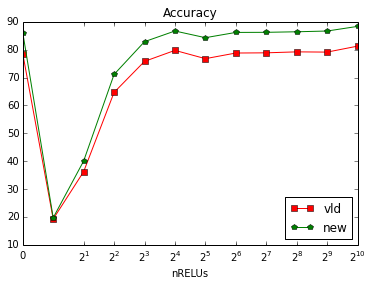

In [52]:
plt.figure()
#plt.plot(models['nRELUs'], models['accuracy.fit'], 'bo-', label = 'fit')
plt.plot(models['nRELUs'], models['accuracyVld'], 'rs-', label = 'vld')
plt.plot(models['nRELUs'], models['accuracyTst'], 'gp-', label = 'new')
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.xscale('symlog', basex=2)
axes = plt.gca()
axes.set_xlabel('nRELUs')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()